In [1]:
import v3io.dataplane
import mlrun

In [2]:
v3io_client = v3io.dataplane.Client()

In [3]:
CONTAINER = "energy_project_data"

In [4]:
from os import getenv, path

V3IO_USERNAME = getenv('V3IO_USERNAME')
OBJECTS_PATH = path.join(V3IO_USERNAME, 'examples', 'v3io', 'engery_project_data')

In [5]:
OBJECT = path.join(OBJECTS_PATH, 'nz_flattened.csv')
print(OBJECT)
import os
print(os.listdir('/User/v3io/engery_project_data'))


#response = v3io_client.object.get(container=CONTAINER, path=OBJECT)
#print(response.body.decode('utf-8'))

caleb/examples/v3io/engery_project_data/nz_flattened.csv
['.ipynb_checkpoints', '.oos', 'Auckland.csv', 'Gisborn.csv', 'Hamilton.csv', 'Kaitaia.csv', 'Masterton.csv', 'Naiper.csv', 'NewPlymonth.csv', 'Rotorua.csv', 'Taupo.csv', 'Taurange.csv', 'Whangarai.csv', 'nz-street-address.csv', 'nz_flattened.csv', 'palmy.csv']


In [7]:
project_name_base = 'the-super-models-super-energy-project'
# Initialize the MLRun environment and save the project name and artifacts path
project_name, artifact_path = mlrun.set_environment(project=project_name_base,
                                                    user_project=False)
                                                    
# Display the current project name and artifacts path
print(f'Project name: {project_name}')
print(f'Artifacts path: {artifact_path}')

Project name: the-super-models-super-energy-project
Artifacts path: v3io:///projects/{{run.project}}/artifacts


In [8]:
# nuclio: start-code

In [9]:
import pandas as pd
def sunshine_data_generator(context, location='/User/v3io/engery_project_data/nz_flattened.csv', feature_columns=['Latitude', 'Longitude'], format='csv'):
    sunshine_df = pd.read_csv(location)
    sunshine_df
    
    context.logger.info('saving sunshine dataframe to {}'.format(context.artifact_path))
    context.log_result('num_rows', sunshine_df.shape[0])
    context.log_dataset('sunshine_dataset', df=sunshine_df, format=format, index=False)
    

In [10]:
# nuclio: end-code

In [11]:
# Convert the local prep_data function to an MLRun project function
data_prep_func = mlrun.code_to_function(name='sunshine_data_raw', kind='job', image='mlrun/ml-models')

In [12]:
# Run the `data_prep_func` MLRun function locally
prep_data_run = data_prep_func.run(name='sunshine_data_raw',
                                   handler=sunshine_data_generator,
                                   inputs={},
                                   local=True)

> 2021-06-21 08:04:43,991 [info] starting run sunshine_data_raw uid=424584912da34b1fa9211671e6433a5a DB=http://mlrun-api:8080
> 2021-06-21 08:04:45,700 [info] saving sunshine dataframe to v3io:///projects/the-super-models-super-energy-project/artifacts


to track results use .show() or .logs() or in CLI: 
!mlrun get run 424584912da34b1fa9211671e6433a5a --project the-super-models-super-energy-project , !mlrun logs 424584912da34b1fa9211671e6433a5a --project the-super-models-super-energy-project
> 2021-06-21 08:04:48,434 [info] run executed, status=completed


In [45]:
print(prep_data_run.outputs)
prep_data_run.state()

{'num_rows': 396668, 'sunshine_dataset': 'store://artifacts/the-super-models-super-energy-project/sunshine_data_raw_sunshine_dataset:424584912da34b1fa9211671e6433a5a'}


'completed'

In [14]:
data_item = prep_data_run.outputs['sunshine_dataset']

In [15]:
dataset = mlrun.run.get_dataitem(data_item)

In [16]:
dataset.as_df().head()

Station  Date(NZST)  Amount(Hrs)  Period(Hrs) Freq      StationName  \
0    15752  11/06/2019          2.6           24    D          Dunedin   
1    17244  11/06/2019          0.4           24    D     Rangiora Ews   
2    17603  11/06/2019          0.4           24    D          Lincoln   
3    18125  11/06/2019          0.6           24    D      Mt Cook Ews   
4    18437  11/06/2019          1.1           24    D  Middlemarch Ews   

   Latitude  Longitude  Height NetworkNumber OriginalFileIdentifier  DayOfYear  
0 -45.90129  170.51470       4        I50954            Duniden.csv        162  
1 -43.32858  172.61114      23        H32364            Duniden.csv        162  
2 -43.62622  172.47040      18        H32645            Duniden.csv        162  
3 -43.73600  170.09600     730        H30706            Duniden.csv        162  
4 -45.51814  170.13561     213        I50513            Duniden.csv        162

## Start Training Code

In [48]:
# nuclio: start-code

In [49]:
from sklearn import linear_model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from cloudpickle import dumps
import pandas as pd

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.mlutils.data import get_sample
from mlrun.mlutils.plots import eval_model_v2

In [78]:
raw, labels, header = get_sample(dataset, sample=-1, label="Amount(Hrs)")
X_train, X_test, y_train, y_test = train_test_split(raw[['Latitude', 'Longitude', 'DayOfYear']], labels, test_size=0.2, random_state=42)
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
print(raw.describe())
print(labels.describe())
print(pd.DataFrame(model.predict(raw[['Latitude', 'Longitude', 'DayOfYear']])).describe())

             Station  Period(Hrs)       Latitude      Longitude  \
count  396667.000000     396667.0  396667.000000  396667.000000   
mean    23515.117280         24.0     -41.358109     173.521679   
std     14085.311376          0.0       2.649576       2.385315   
min      1529.000000         24.0     -46.900510     168.128510   
25%      8567.000000         24.0     -43.493000     171.805000   
50%     24945.000000         24.0     -41.270580     173.962850   
75%     38057.000000         24.0     -39.951500     175.332000   
max     43967.000000         24.0     -35.133520     177.985000   

              Height      DayOfYear  
count  396667.000000  396667.000000  
mean      101.226036     185.173896  
std       142.178998     104.999749  
min         0.000000       1.000000  
25%         7.000000      95.000000  
50%        45.000000     187.000000  
75%       130.000000     275.000000  
max       762.000000     366.000000  
count    396667.000000
mean          5.915629
std     

In [51]:
def train_sunshine(context: MLClientCtx,
               dataset: DataItem,
               features_columns: ['Latitude', 'Longitude', 'DayOfYear'],
               label_column: str = "Amount(Hrs)"):

    raw, labels, header = get_sample(dataset, sample=-1, label=label_column)
    
    # Basic scikit-learn Iris data-set SVM model
    X_train, X_test, y_train, y_test = train_test_split(
        raw[features_columns], labels, test_size=0.2, random_state=42)
    
    context.log_dataset('train_set', 
                        df=pd.concat([X_train, y_train.to_frame()], axis=1),
                        format='csv', index=False, 
                        artifact_path=context.artifact_subpath('data'))

    context.log_dataset('test_set', 
                        df=pd.concat([X_test, y_test.to_frame()], axis=1),
                        format='csv', index=False, 
                        labels={"data-type": "held-out"},
                        artifact_path=context.artifact_subpath('data'))
    
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluate model results and get the evaluation metrics
    #eval_metrics = eval_model_v2(context, X_test, y_test, model)
    
    # Log model
    context.log_model("model",
                      body=dumps(model),
                      artifact_path=context.artifact_subpath("models"),
                      #extra_data=eval_metrics, 
                      model_file="model.pkl",
                      metrics=context.results,
                      labels={"class": "sklearn.linear_model.LinearRegression"})

In [52]:
# nuclio: end-code

In [53]:
train_sunshine_func = mlrun.code_to_function(name='train_sunshine',
                                         handler='train_sunshine',
                                         kind='job',
                                         image='mlrun/ml-models')

In [54]:
from mlrun.platforms import auto_mount
train_sunshine_func = train_sunshine_func.apply(auto_mount())

In [55]:
dataset_string = 'store://artifacts/the-super-models-super-energy-project/sunshine_data_raw_sunshine_dataset'
train_run = train_sunshine_func.run(inputs={'dataset': dataset_string},
                                params={'features_columns': ['Latitude', 'Longitude', 'DayOfYear'], 'label_column':'Amount(Hrs)'})

> 2021-06-21 08:52:32,594 [info] starting run train-sunshine-train_sunshine uid=79393011b2d04af0811f8bf9dcabc16b DB=http://mlrun-api:8080
> 2021-06-21 08:52:32,794 [info] Job is running in the background, pod: train-sunshine-train-sunshine-k8kdm
> 2021-06-21 08:52:42,875 [info] run executed, status=completed
final state: completed


to track results use .show() or .logs() or in CLI: 
!mlrun get run 79393011b2d04af0811f8bf9dcabc16b --project the-super-models-super-energy-project , !mlrun logs 79393011b2d04af0811f8bf9dcabc16b --project the-super-models-super-energy-project
> 2021-06-21 08:52:52,082 [info] run executed, status=completed


In [56]:
print (train_run.outputs['model'])

store://artifacts/the-super-models-super-energy-project/train-sunshine-train_sunshine_model:79393011b2d04af0811f8bf9dcabc16b


In [59]:
print(train_run.outputs)

{'train_set': 'store://artifacts/the-super-models-super-energy-project/train-sunshine-train_sunshine_train_set:79393011b2d04af0811f8bf9dcabc16b', 'test_set': 'store://artifacts/the-super-models-super-energy-project/train-sunshine-train_sunshine_test_set:79393011b2d04af0811f8bf9dcabc16b', 'model': 'store://artifacts/the-super-models-super-energy-project/train-sunshine-train_sunshine_model:79393011b2d04af0811f8bf9dcabc16b'}


In [60]:
describe = mlrun.import_function('hub://describe').apply(auto_mount())
describe.doc()

In [61]:
describe_run = describe.run(params={'label_column': 'Amount(Hrs)'},
                            inputs={"table":
                                    train_run.outputs['test_set']})

> 2021-06-21 08:56:40,576 [info] starting run describe-summarize uid=394c4759b6ee44db988654a6ffbcb636 DB=http://mlrun-api:8080
> 2021-06-21 08:56:40,783 [info] Job is running in the background, pod: describe-summarize-t7nlh
> 2021-06-21 08:57:26,351 [info] run executed, status=completed
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
final state: completed


to track results use .show() or .logs() or in CLI: 
!mlrun get run 394c4759b6ee44db988654a6ffbcb636 --project the-super-models-super-energy-project , !mlrun logs 394c4759b6ee44db988654a6ffbcb636 --project the-super-models-super-energy-project
> 2021-06-21 08:57:30,222 [info] run executed, status=completed



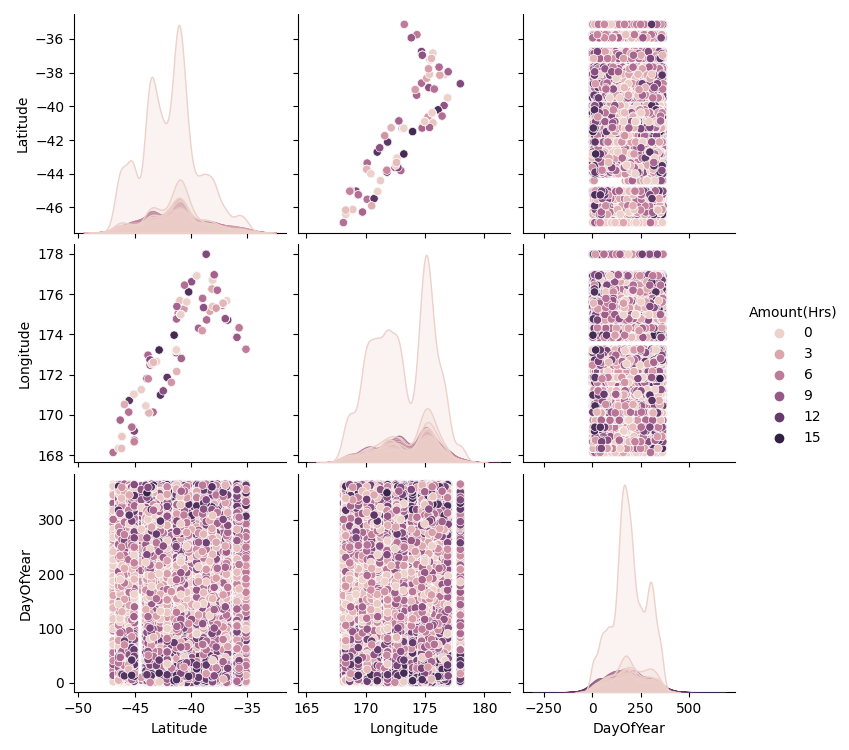

In [63]:
from IPython.display import display, HTML
display(HTML(mlrun.get_dataitem(describe_run.outputs['histograms']).get().decode('utf-8')))


### Serving Sections

In [65]:
# nuclio: start-code

In [66]:
from cloudpickle import load
import numpy as np
from typing import List
import mlrun

class RegressionModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [67]:
# nuclio: end-code

In [68]:
from mlrun import code_to_function
serving_fn = code_to_function('serving', kind='serving',image='mlrun/mlrun')
serving_fn.spec.default_class = 'RegressionModel'

In [69]:
model_file = 'store://artifacts/the-super-models-super-energy-project/train-sunshine-train_sunshine_model'
serving_fn.add_model('my_model',model_path=model_file)

In [70]:
from mlrun.platforms import auto_mount
serving_fn = serving_fn.apply(auto_mount())

In [83]:
my_data = '''{"inputs":[[-44, 171, 123],[-44, 171, 1], [-44, 171, 365]]}'''

In [84]:
server = serving_fn.to_mock_server()
server.test("/v2/models/my_model/infer", body=my_data)

> 2021-06-21 09:16:46,265 [info] model my_model was loaded
> 2021-06-21 09:16:46,266 [info] Loaded ['my_model']


{'id': 'a37432eda17144548d421764f89d1db0',
 'model_name': 'my_model',
 'outputs': [5.665686715044465, 5.8418640785763145, 5.3162201414812955]}

In [85]:
function_address = serving_fn.deploy()

> 2021-06-21 09:17:05,317 [info] Starting remote function deploy
2021-06-21 09:17:05  (info) Deploying function
2021-06-21 09:17:05  (info) Building
2021-06-21 09:17:05  (info) Staging files and preparing base images
2021-06-21 09:17:05  (info) Building processor image
2021-06-21 09:17:11  (info) Build complete
2021-06-21 09:17:21  (info) Function deploy complete
> 2021-06-21 09:17:22,071 [info] function deployed, address=default-tenant.app.mlops4.iguazio-c0.com:32447


In [86]:
print (f'The address for the function is {function_address} \n')

!curl $function_address

The address for the function is http://default-tenant.app.mlops4.iguazio-c0.com:32447 

{"name": "ModelRouter", "version": "v2", "extensions": []}

In [95]:
serving_fn.invoke('/v2/models/my_model/infer', my_data)

{'id': '364a46a0-0fd0-4132-8add-db6833264e52',
 'model_name': 'my_model',
 'outputs': [5.665686715044465, 5.8418640785763145, 5.3162201414812955]}

In [98]:
import requests
import json
predict_url = f'http://default-tenant.app.mlops4.iguazio-c0.com:32447/v2/models/my_model/infer'
resp = requests.post(predict_url, json=my_data)
print(resp.json())

{'id': '67c1493f-ffad-4f4c-9f1c-f1d81bae6d08', 'model_name': 'my_model', 'outputs': [5.665686715044465, 5.8418640785763145, 5.3162201414812955]}
